### **1. Chuẩn bị tập dữ liệu**

#### 1.1 Import thư viện

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from IPython.display import Image, display
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

#### 1.2 Xử lý dữ liệu

In [2]:
# Tải dữ liệu UCI Heart Disease từ ucimlrepo
heart_disease = fetch_ucirepo(id=45)
X = heart_disease.data.features
y = heart_disease.data.targets.squeeze()  # Loại bỏ cột đơn nếu tồn tại

# Kết hợp lại thành một DataFrame đầy đủ
df = pd.concat([X, y.rename("target")], axis=1)

# Lưu ra file CSV
df.to_csv("heart_disease.csv", index=False)

print("Đã lưu dữ liệu thành file heart_disease.csv")
# Chuyển y thành nhị phân: 0 = không bệnh, 1 = có bệnh
y_binary = y.copy()
y_binary[y_binary > 0] = 1

df_binary = df.copy()
df_binary['target'] = y_binary
df_binary = df_binary.dropna()
display(df_binary)

Đã lưu dữ liệu thành file heart_disease.csv


age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
0     63    1   1       145   233    1        2      150      0      2.3   
1     67    1   4       160   286    0        2      108      1      1.5   
2     67    1   4       120   229    0        2      129      1      2.6   
3     37    1   3       130   250    0        0      187      0      3.5   
4     41    0   2       130   204    0        2      172      0      1.4   
..   ...  ...  ..       ...   ...  ...      ...      ...    ...      ...   
297   57    0   4       140   241    0        0      123      1      0.2   
298   45    1   1       110   264    0        0      132      0      1.2   
299   68    1   4       144   193    1        0      141      0      3.4   
300   57    1   4       130   131    0        0      115      1      1.2   
301   57    0   2       130   236    0        2      174      0      0.0   

     slope   ca  thal  target  
0        3  0.0   6.0       0  
1        2  3.0   3.0       1  
2        2  2.0   7.0       1  
3        3  0.0   3.0       0  
4        1  0.0   3.0       0  
..     ...  ...   ...     ...  
297      2  0.0   7.0       1  
298      2  0.0   7.0       1  
299      2  2.0   7.0       1  
300      2  1.0   7.0       1  
301      2  1.0   3.0       1  

[297 rows x 14 columns]

#### 1.3 Chia dữ liệu

In [3]:
def stratified_split(X, y, train_size, random_state=42):
    """
    Chia dữ liệu theo kiểu phân tầng.
    
    Parameters:
    - X: Dữ liệu đầu vào (features)
    - y: Nhãn (labels)
    - test_size: Tỷ lệ dữ liệu test
    - random_state: Giá trị seed để tái tạo
    
    Returns:
    - feature_train, feature_test, label_train, label_test: Dữ liệu sau khi chia
    """
    test_size = 1 - train_size
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    return X_train, X_test, y_train, y_test

In [4]:
os.makedirs('./output/train_test', exist_ok=True)  

def visualize_train_test_distribution(y, y_train, y_test, train_size):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharey=True)
    
    label = [0, 1]
    
    for ax in axes:
        ax.set_xticks([0, 1])  # Chỉ hiển thị 0 và 1 trên trục x
        ax.set_xlim(-0.5, 1.5)  # Giữ khoảng trục x cố định
    
    # Phân phối gốc
    original_counts = [Counter(y)[ele] for ele in label]
    axes[0].bar(label, original_counts)
    axes[0].set_title('Original Dataset')
    axes[0].set_ylabel('Count')
    for i, count in enumerate(original_counts):
        axes[0].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập train
    train_counts = [Counter(y_train)[ele] for ele in label]
    axes[1].bar(label, train_counts)
    axes[1].set_title(f'Training Set ({int(round(train_size, 2)* 100)}%)')
    for i, count in enumerate(train_counts):
        axes[1].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    # Phân phối tập test
    test_counts = [Counter(y_test)[ele] for ele in label]
    axes[2].bar(label, test_counts)
    axes[2].set_title(f'Test Set ({int(round((1 - train_size), 2) * 100)}%)')
    for i, count in enumerate(test_counts):
        axes[2].text(i, count + 1, str(count), ha='center', va='bottom', fontsize=15)

    plt.tight_layout()
    plt.savefig(f'./output/train_test/train_test_{int(train_size*100)}_{int(round(1 - train_size, 2) * 100)}.png', format='png', bbox_inches='tight')
    plt.show()


##### Visualize Data sau khi chia tỷ lệ

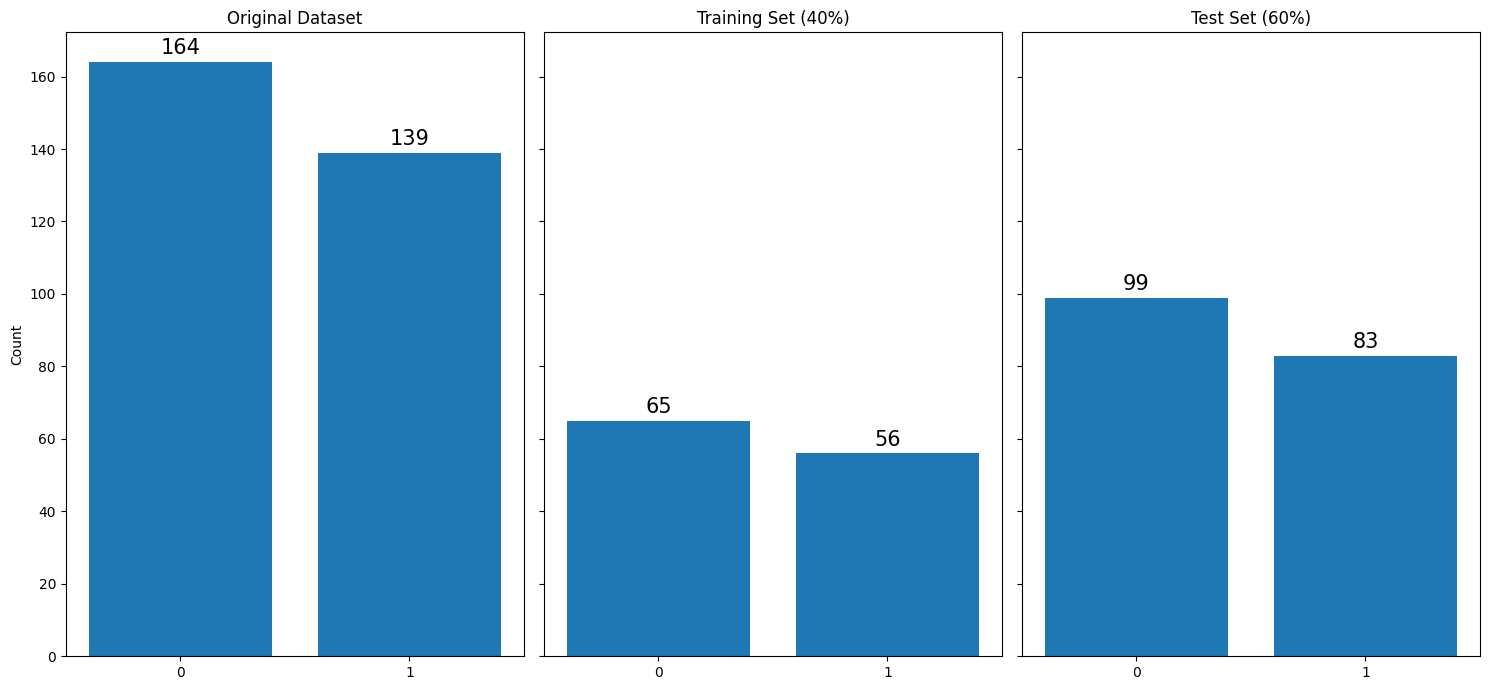

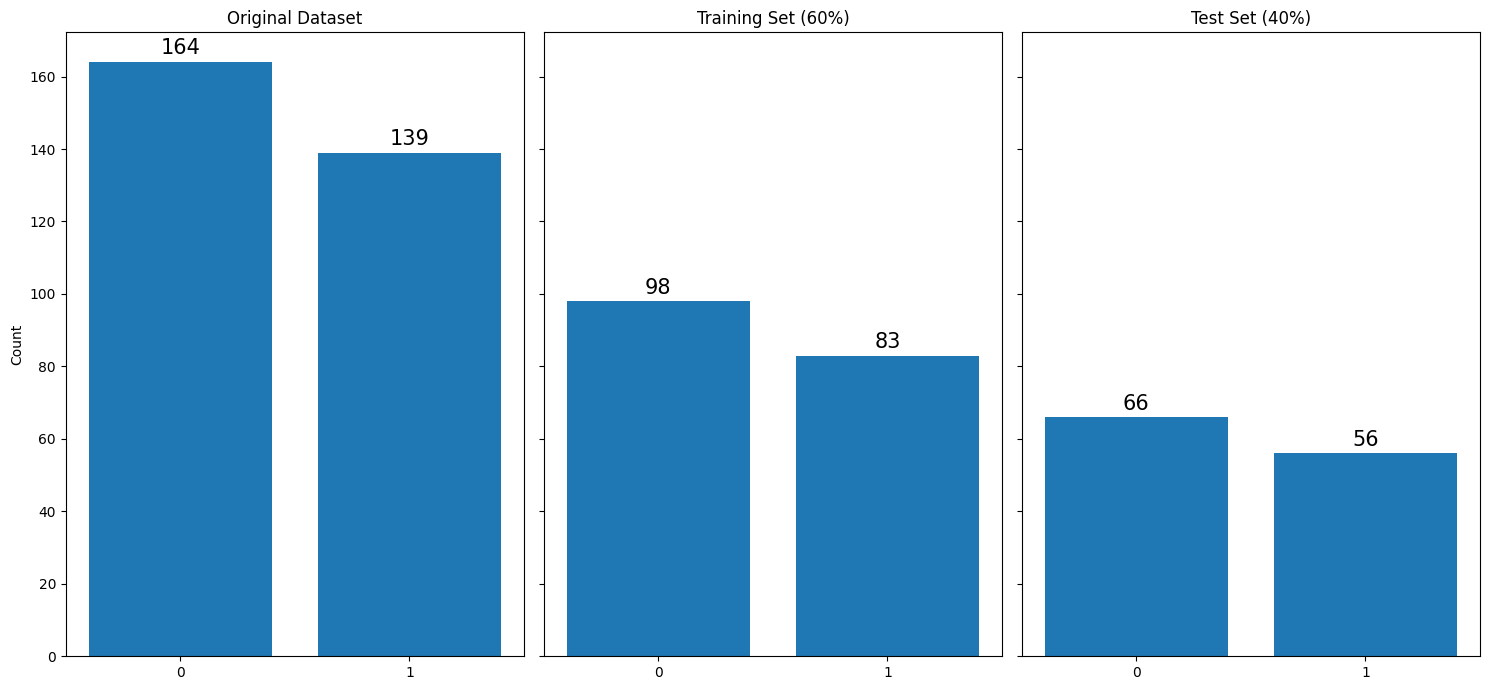

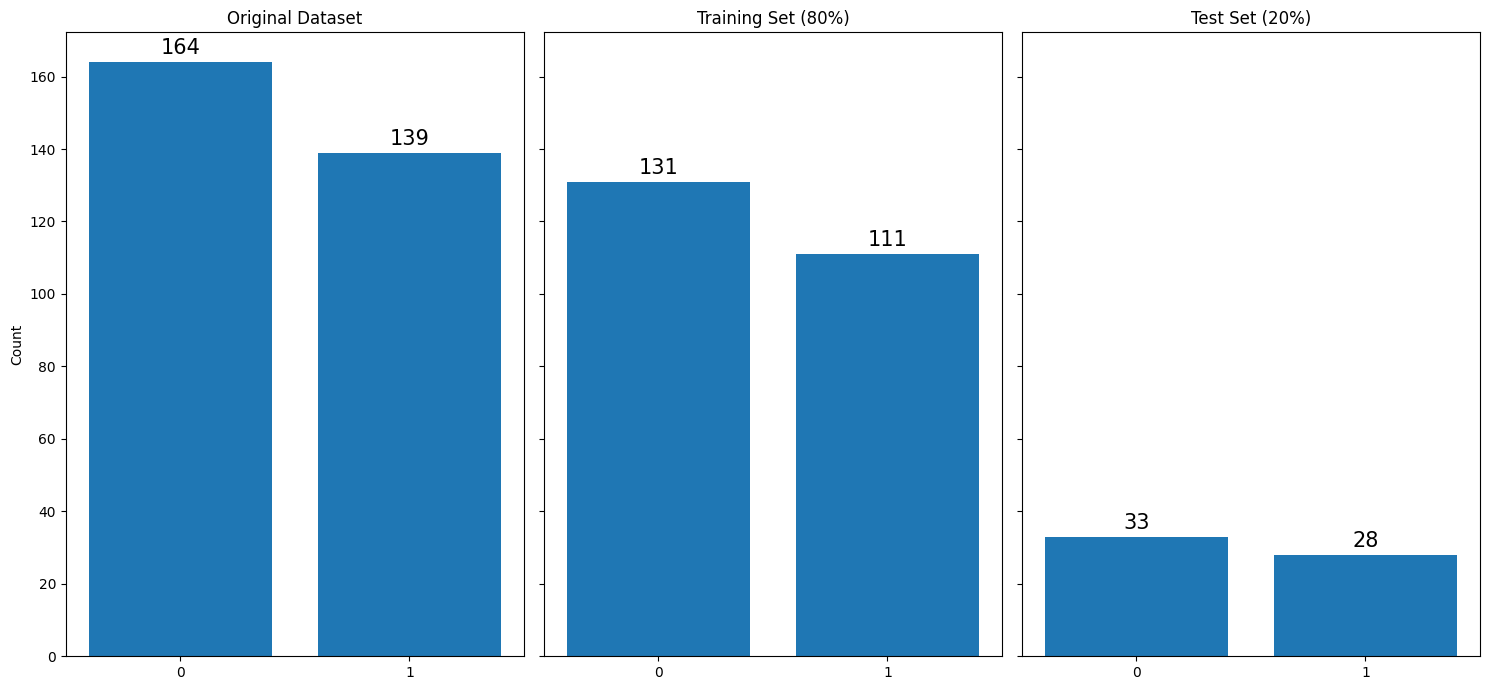

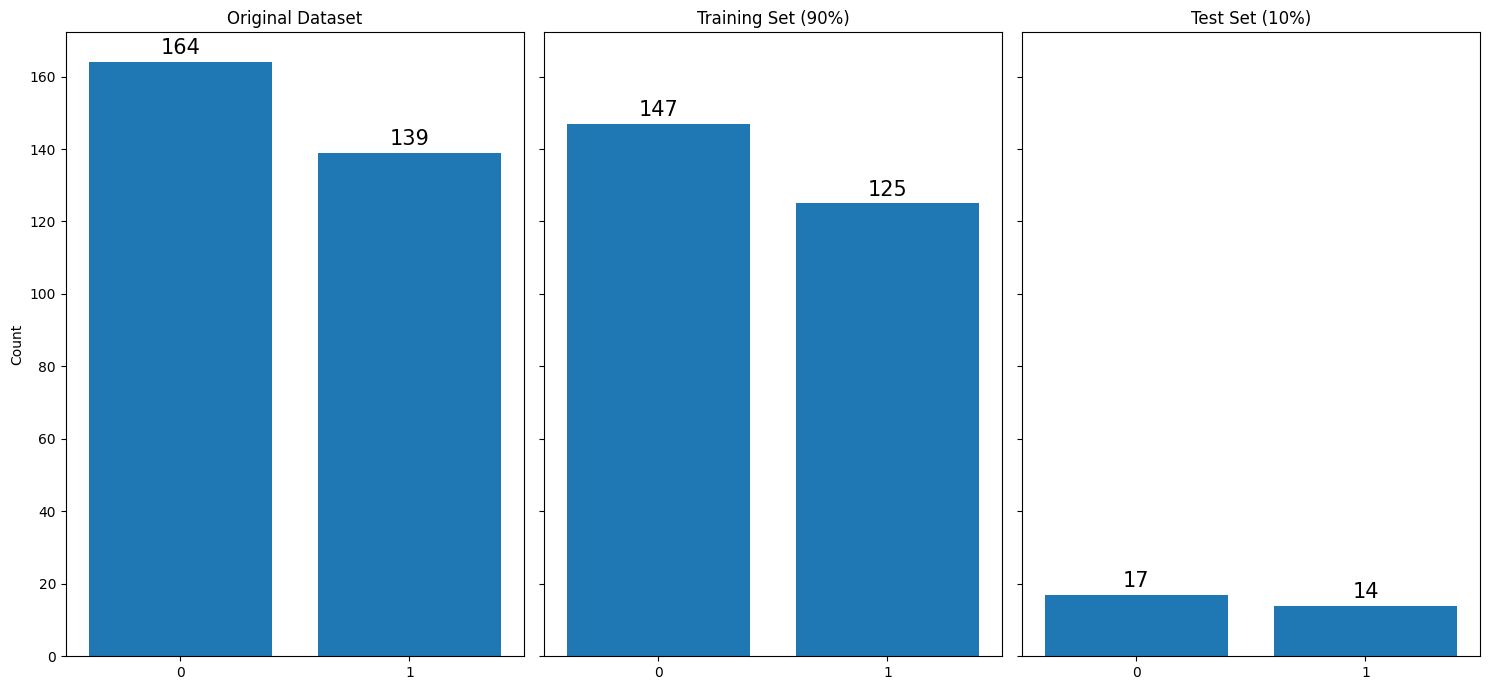

In [5]:
ratios = [0.4, 0.6, 0.8, 0.9]

split_train_test = {}  # Dùng để lưu các tập sau khi chia
for train_size in ratios:
    feature_train, feature_test, label_train, label_test = stratified_split(X,y_binary, train_size, random_state=42)
    visualize_train_test_distribution(y_binary, label_train, label_test, train_size)
    split_train_test[train_size] = {
        'feature_train': feature_train,
        'label_train': label_train,
        'feature_test': feature_test,
        'label_test': label_test
    }

### **2. Xây dựng Decision Tree**


(process:1828): Pango-CRITICAL **: 07:07:38.476: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1828): Pango-CRITICAL **: 07:07:38.476: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1828): Pango-CRITICAL **: 07:07:38.476: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1828): Pango-CRITICAL **: 07:07:38.476: pango_font_description_get_family: assertion 'desc != NULL' failed


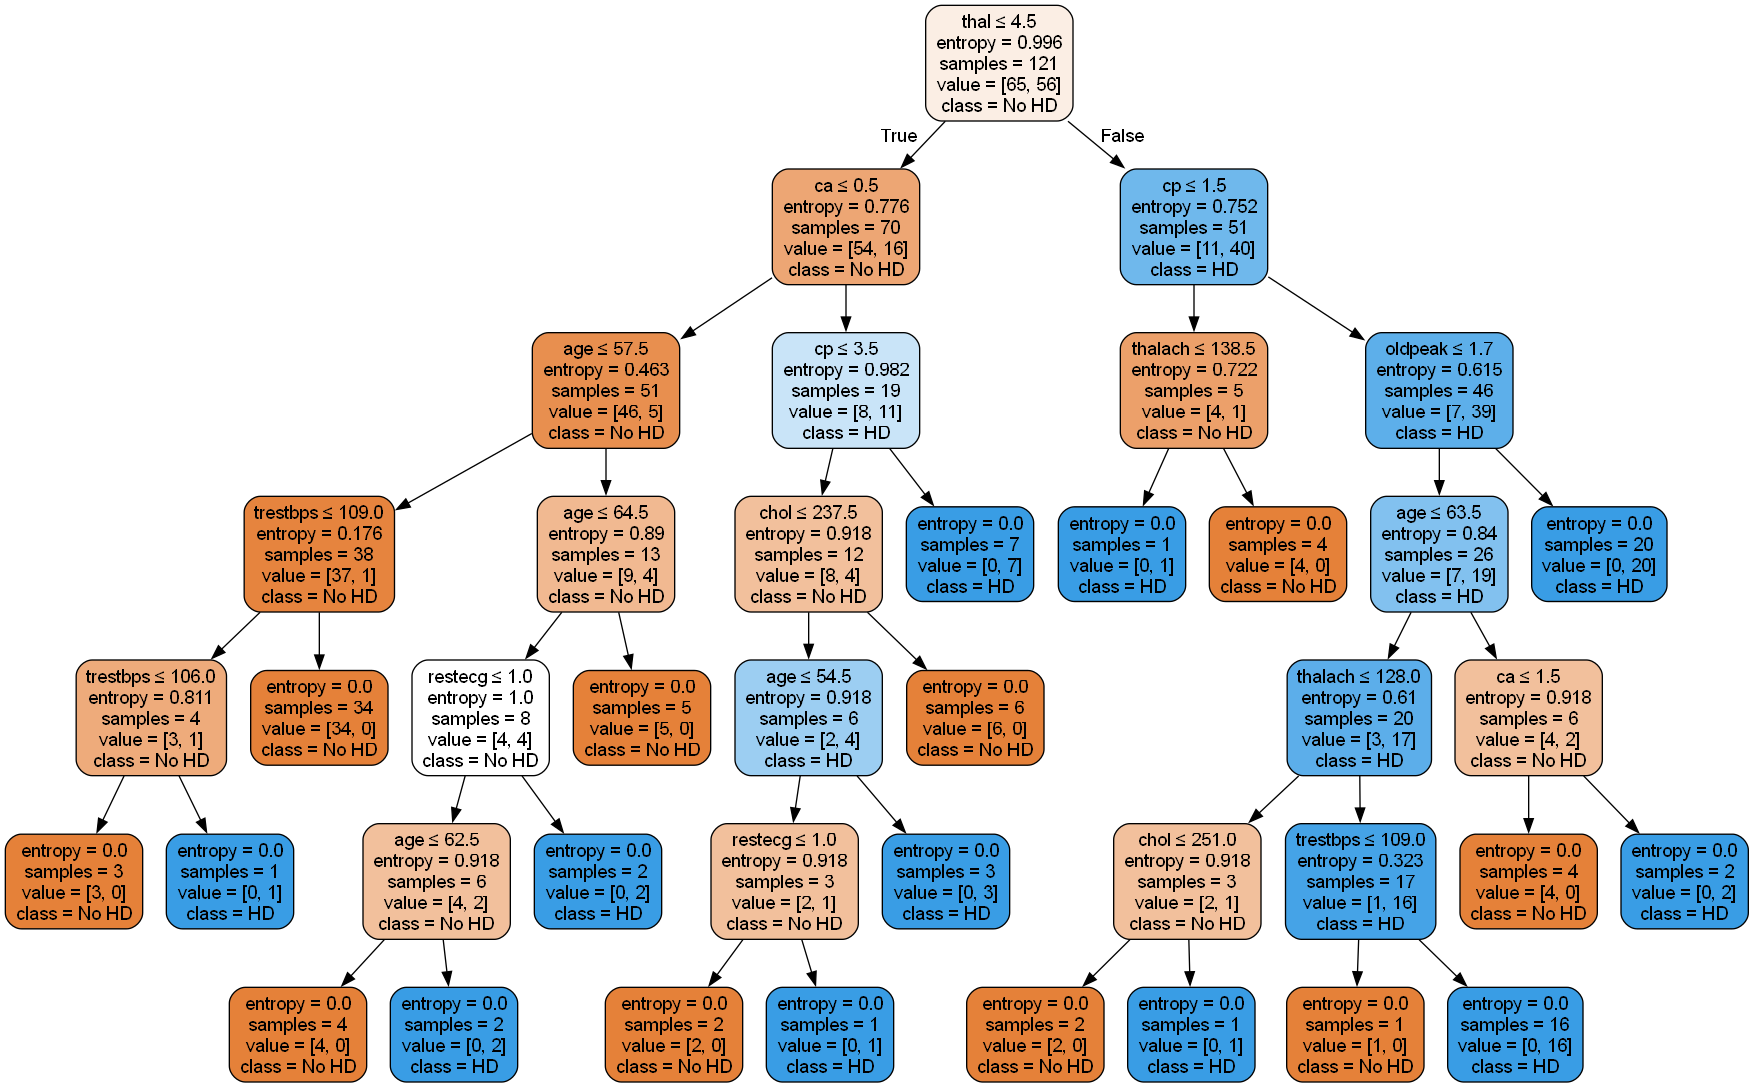


(process:1556): Pango-CRITICAL **: 07:07:39.326: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1556): Pango-CRITICAL **: 07:07:39.326: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1556): Pango-CRITICAL **: 07:07:39.326: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:1556): Pango-CRITICAL **: 07:07:39.326: pango_font_description_get_family: assertion 'desc != NULL' failed


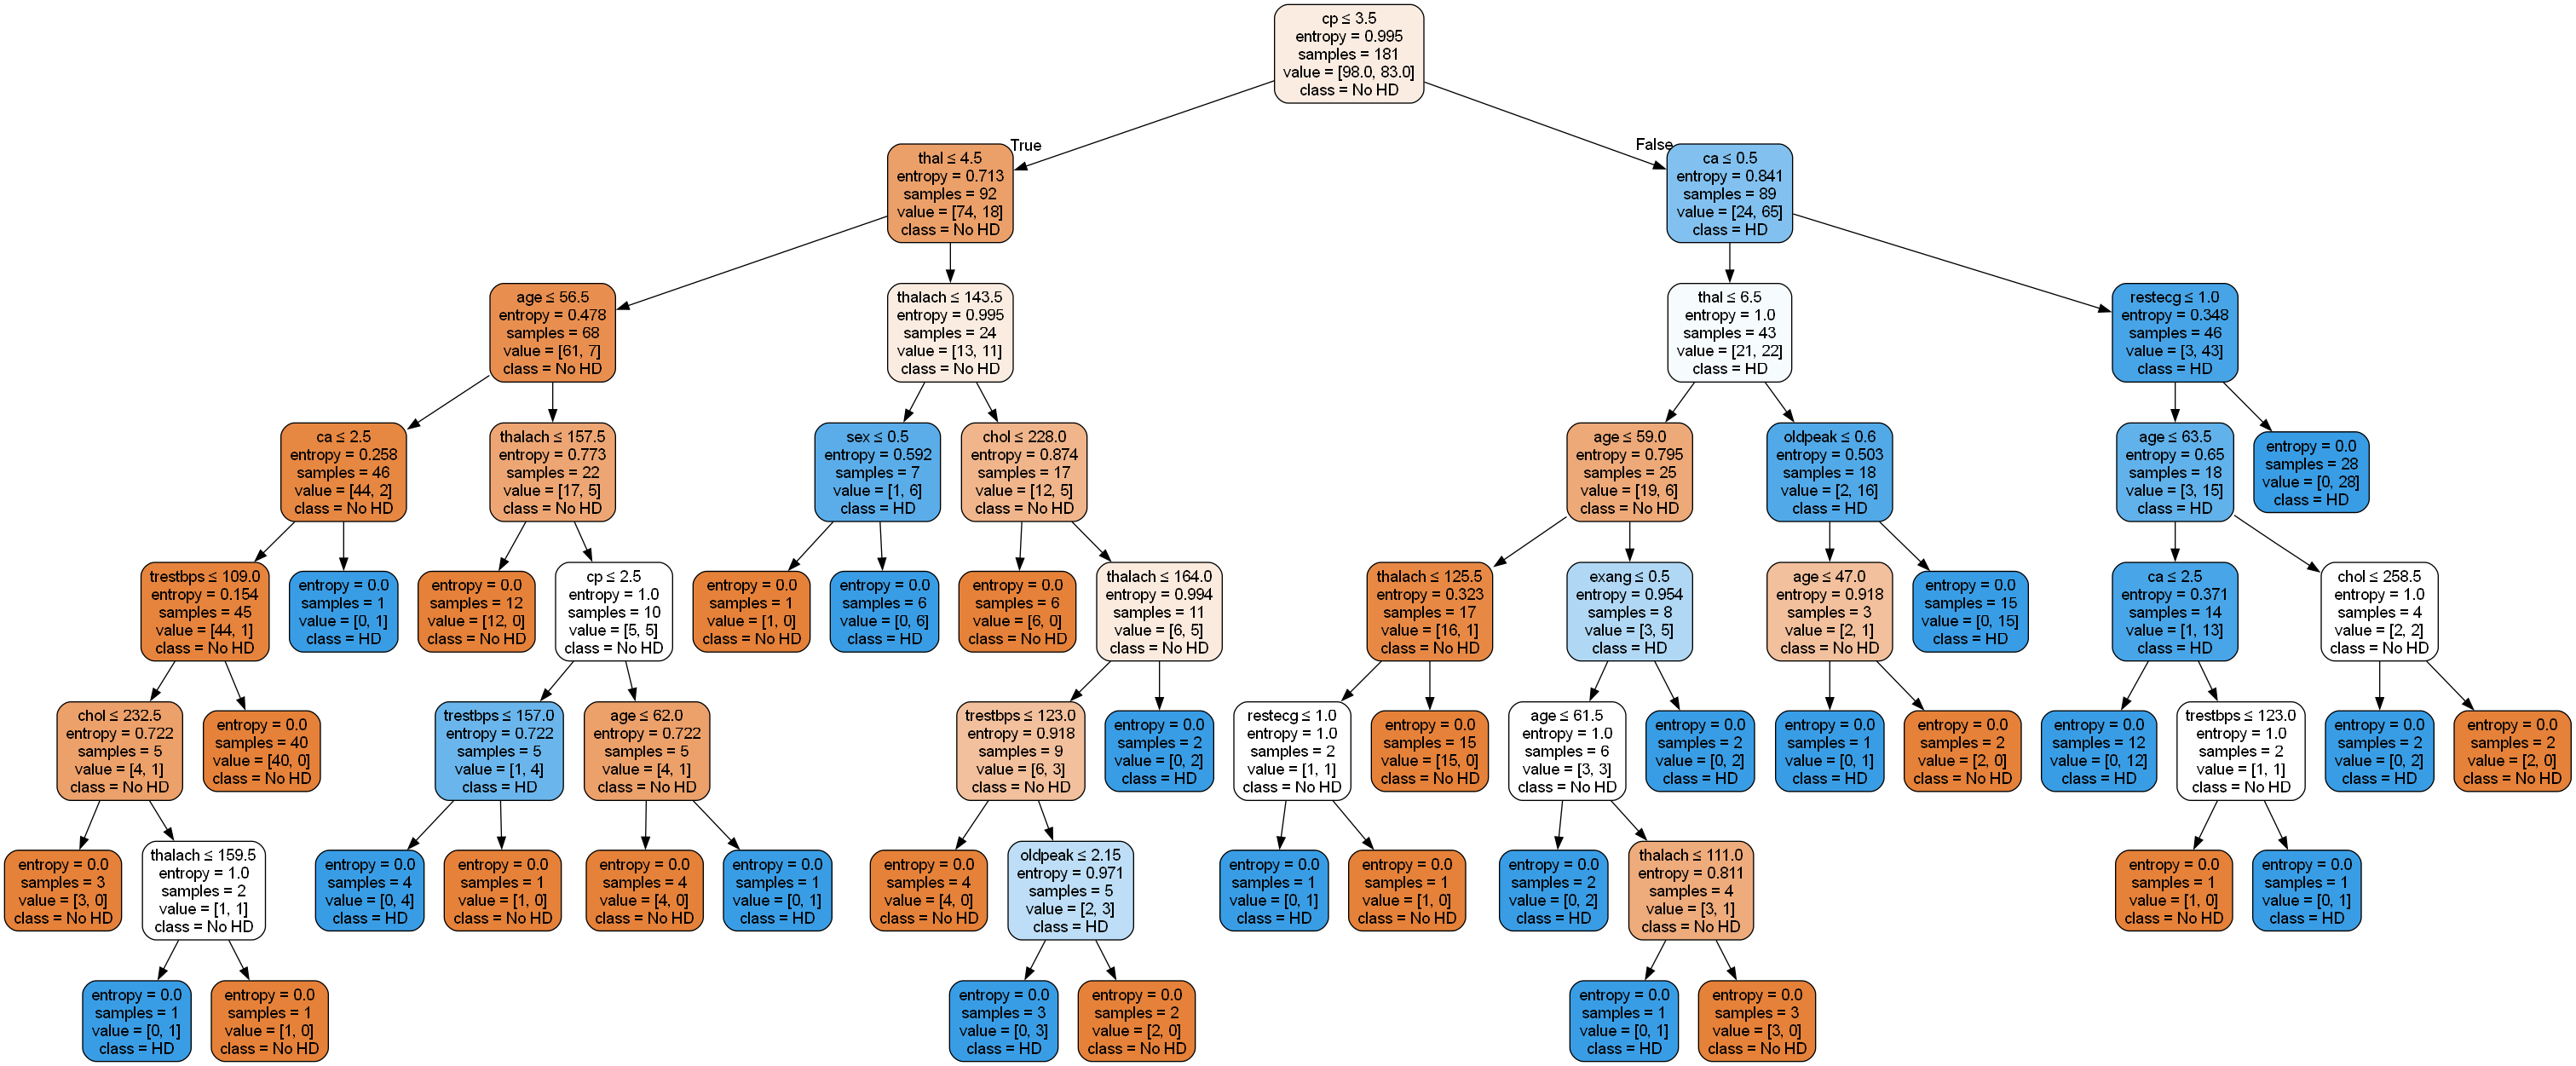


(process:5568): Pango-CRITICAL **: 07:07:40.196: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5568): Pango-CRITICAL **: 07:07:40.196: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5568): Pango-CRITICAL **: 07:07:40.196: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:5568): Pango-CRITICAL **: 07:07:40.196: pango_font_description_get_family: assertion 'desc != NULL' failed


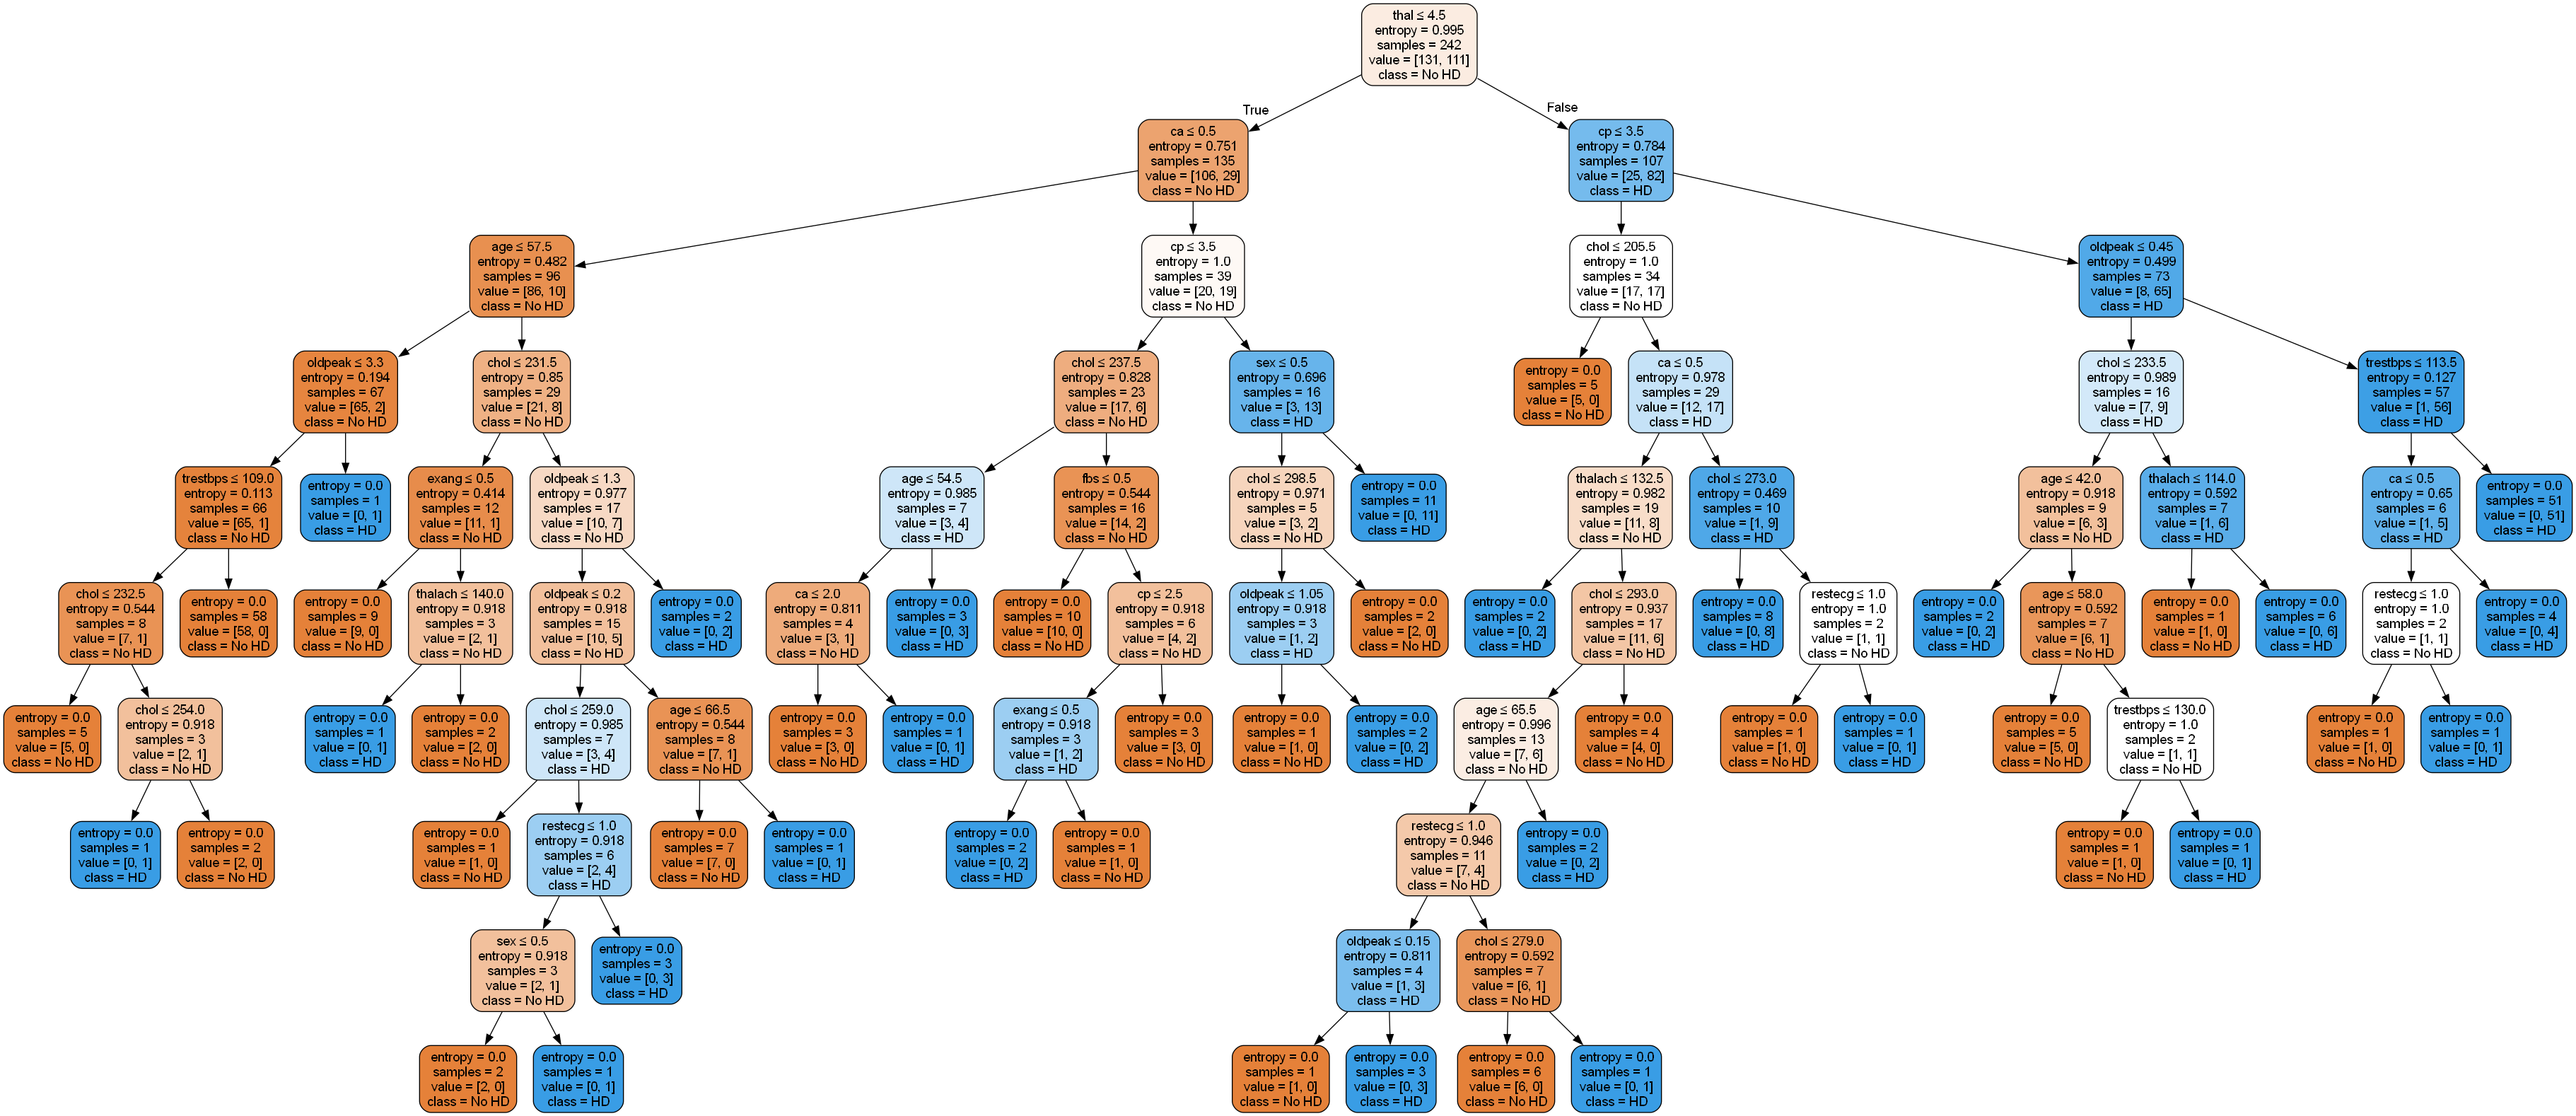


(process:7216): Pango-CRITICAL **: 07:07:41.106: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7216): Pango-CRITICAL **: 07:07:41.106: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7216): Pango-CRITICAL **: 07:07:41.106: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:7216): Pango-CRITICAL **: 07:07:41.106: pango_font_description_get_family: assertion 'desc != NULL' failed


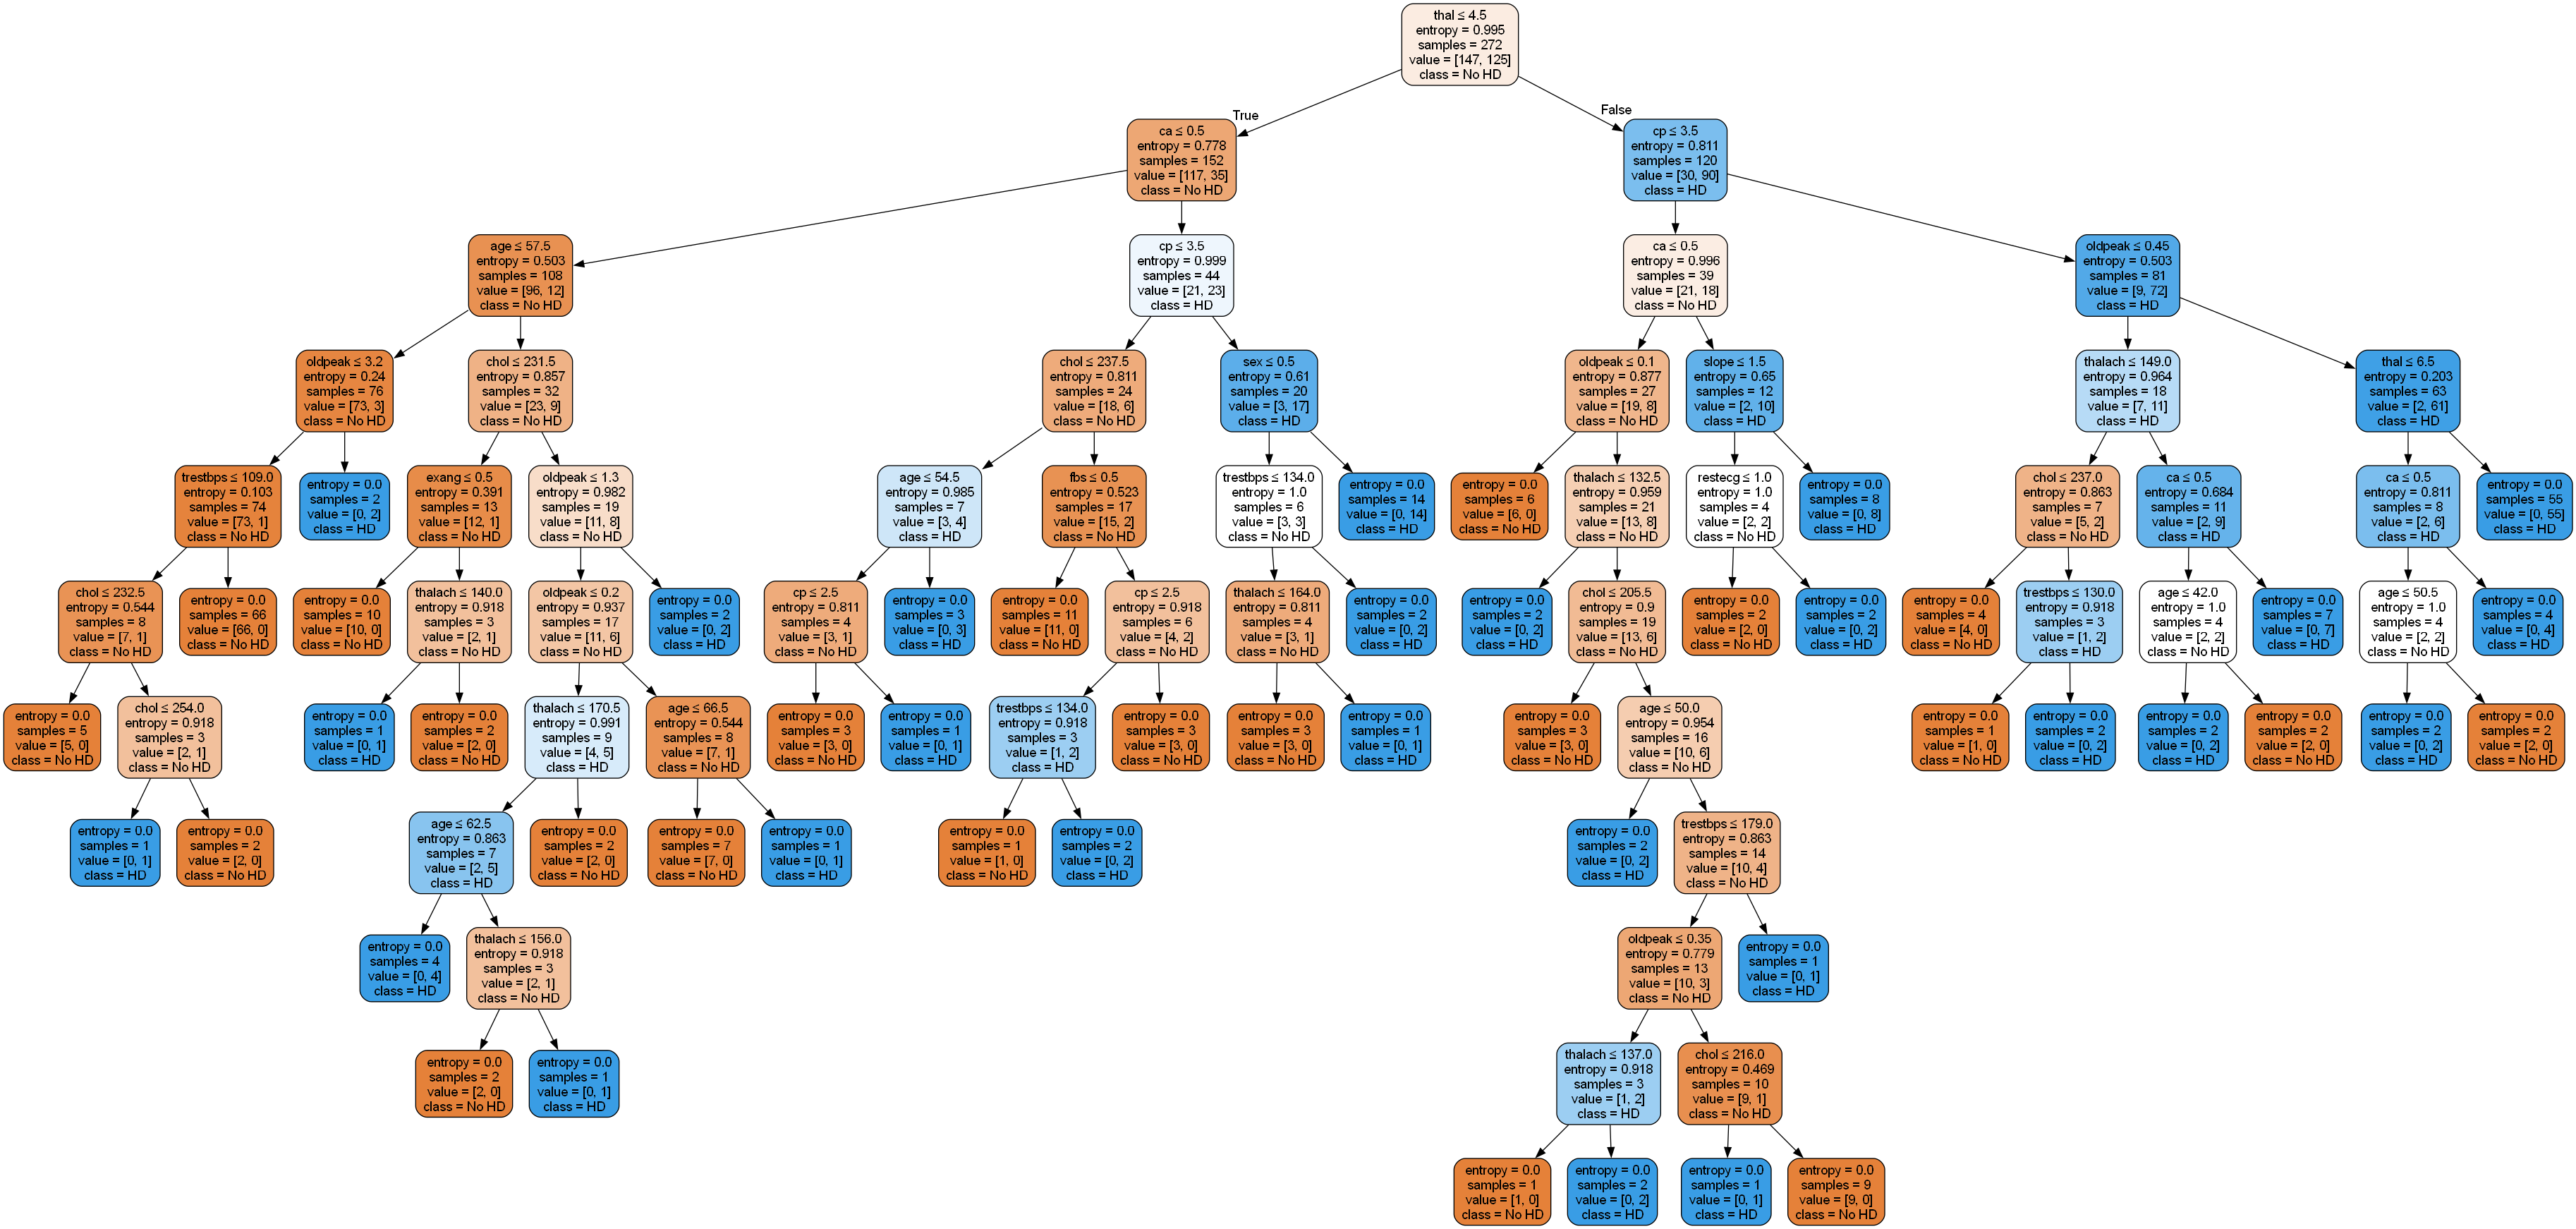

In [ ]:
# ratios = [0.4, 0.6, 0.8, 0.9]
y_trains, y_tests = [], []
decision_tree_path = './output/decision_tree'
os.makedirs(decision_tree_path, exist_ok=True)

for ratio in ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, train_size=ratio, stratify=y_binary, shuffle=True, random_state=42)

    y_trains.append(y_train)
    y_tests.append(y_test)

    # Huấn luyện cây quyết định
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)

    # Trực quan hóa cây
    dot_data = export_graphviz(clf, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['No HD', 'HD'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    
    graph.render(f"{decision_tree_path}/decision_tree_{int(ratio*100)}", format='png', cleanup=True)
    display(Image(f"{decision_tree_path}/decision_tree_{int(ratio*100)}.png"))


### **3. Đánh giá cây quyết định**


==== Classification Report (Train/Test = 40/60) ====
              precision    recall  f1-score   support

       No HD       0.80      0.68      0.73        99
          HD       0.67      0.80      0.73        83

    accuracy                           0.73       182
   macro avg       0.74      0.74      0.73       182
weighted avg       0.74      0.73      0.73       182



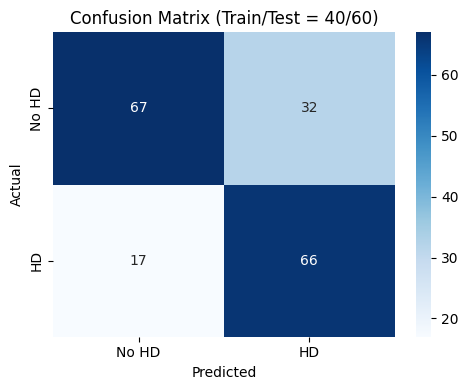


==== Classification Report (Train/Test = 60/40) ====
              precision    recall  f1-score   support

       No HD       0.79      0.74      0.77        66
          HD       0.72      0.77      0.74        56

    accuracy                           0.75       122
   macro avg       0.75      0.76      0.75       122
weighted avg       0.76      0.75      0.75       122



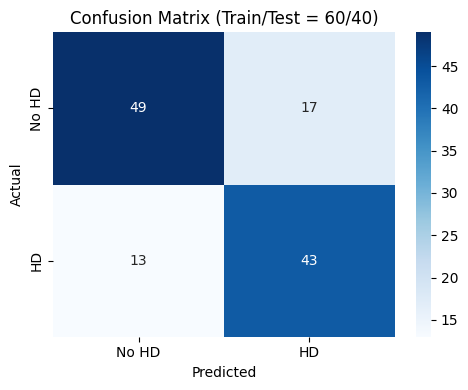


==== Classification Report (Train/Test = 80/20) ====
              precision    recall  f1-score   support

       No HD       0.88      0.67      0.76        33
          HD       0.69      0.89      0.78        28

    accuracy                           0.77        61
   macro avg       0.79      0.78      0.77        61
weighted avg       0.79      0.77      0.77        61



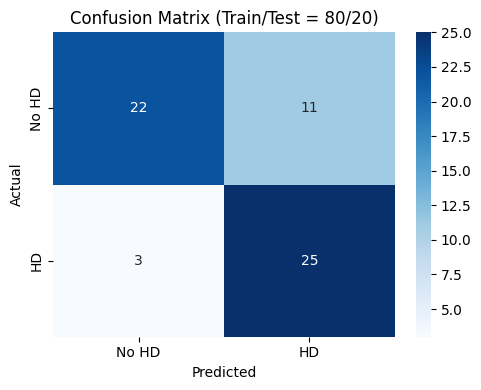


==== Classification Report (Train/Test = 90/10) ====
              precision    recall  f1-score   support

       No HD       0.91      0.59      0.71        17
          HD       0.65      0.93      0.76        14

    accuracy                           0.74        31
   macro avg       0.78      0.76      0.74        31
weighted avg       0.79      0.74      0.74        31



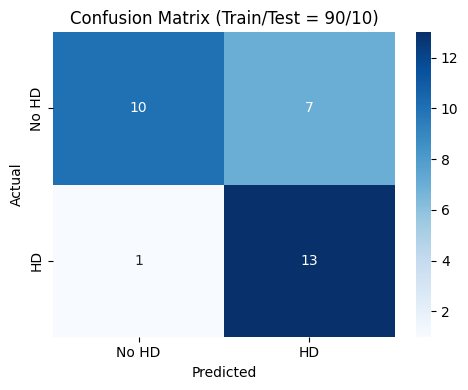

In [7]:
base_confusion_path = './output/confusion_matrix'
os.makedirs(base_confusion_path, exist_ok=True)

for ratio in ratios:
    # Chia lại dữ liệu với y_binary (phân lớp nhị phân)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, train_size=ratio, stratify=y_binary, shuffle=True, random_state=42)

    # Huấn luyện mô hình cây quyết định
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(X_train, y_train)

    # Dự đoán trên tập test
    y_pred = clf.predict(X_test)

    # In báo cáo phân loại
    print(f"\n==== Classification Report (Train/Test = {round(ratio*100)}/{round((1-ratio)*100)}) ====")
    print(classification_report(y_test, y_pred, target_names=['No HD', 'HD']))

    # Tính ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No HD', 'HD'], yticklabels=['No HD', 'HD'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (Train/Test = {round(ratio*100)}/{round((1-ratio)*100)})')
    plt.savefig(f'{base_confusion_path}/confusion_matrix_{int(ratio*100)}.png', format='png', bbox_inches='tight')
    plt.tight_layout()
    plt.show()

### **4 Độ sâu và độ chính xác của cây quyết định**


(process:12376): Pango-CRITICAL **: 07:07:20.864: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12376): Pango-CRITICAL **: 07:07:20.865: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12376): Pango-CRITICAL **: 07:07:20.865: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:12376): Pango-CRITICAL **: 07:07:20.865: pango_font_description_get_family: assertion 'desc != NULL' failed


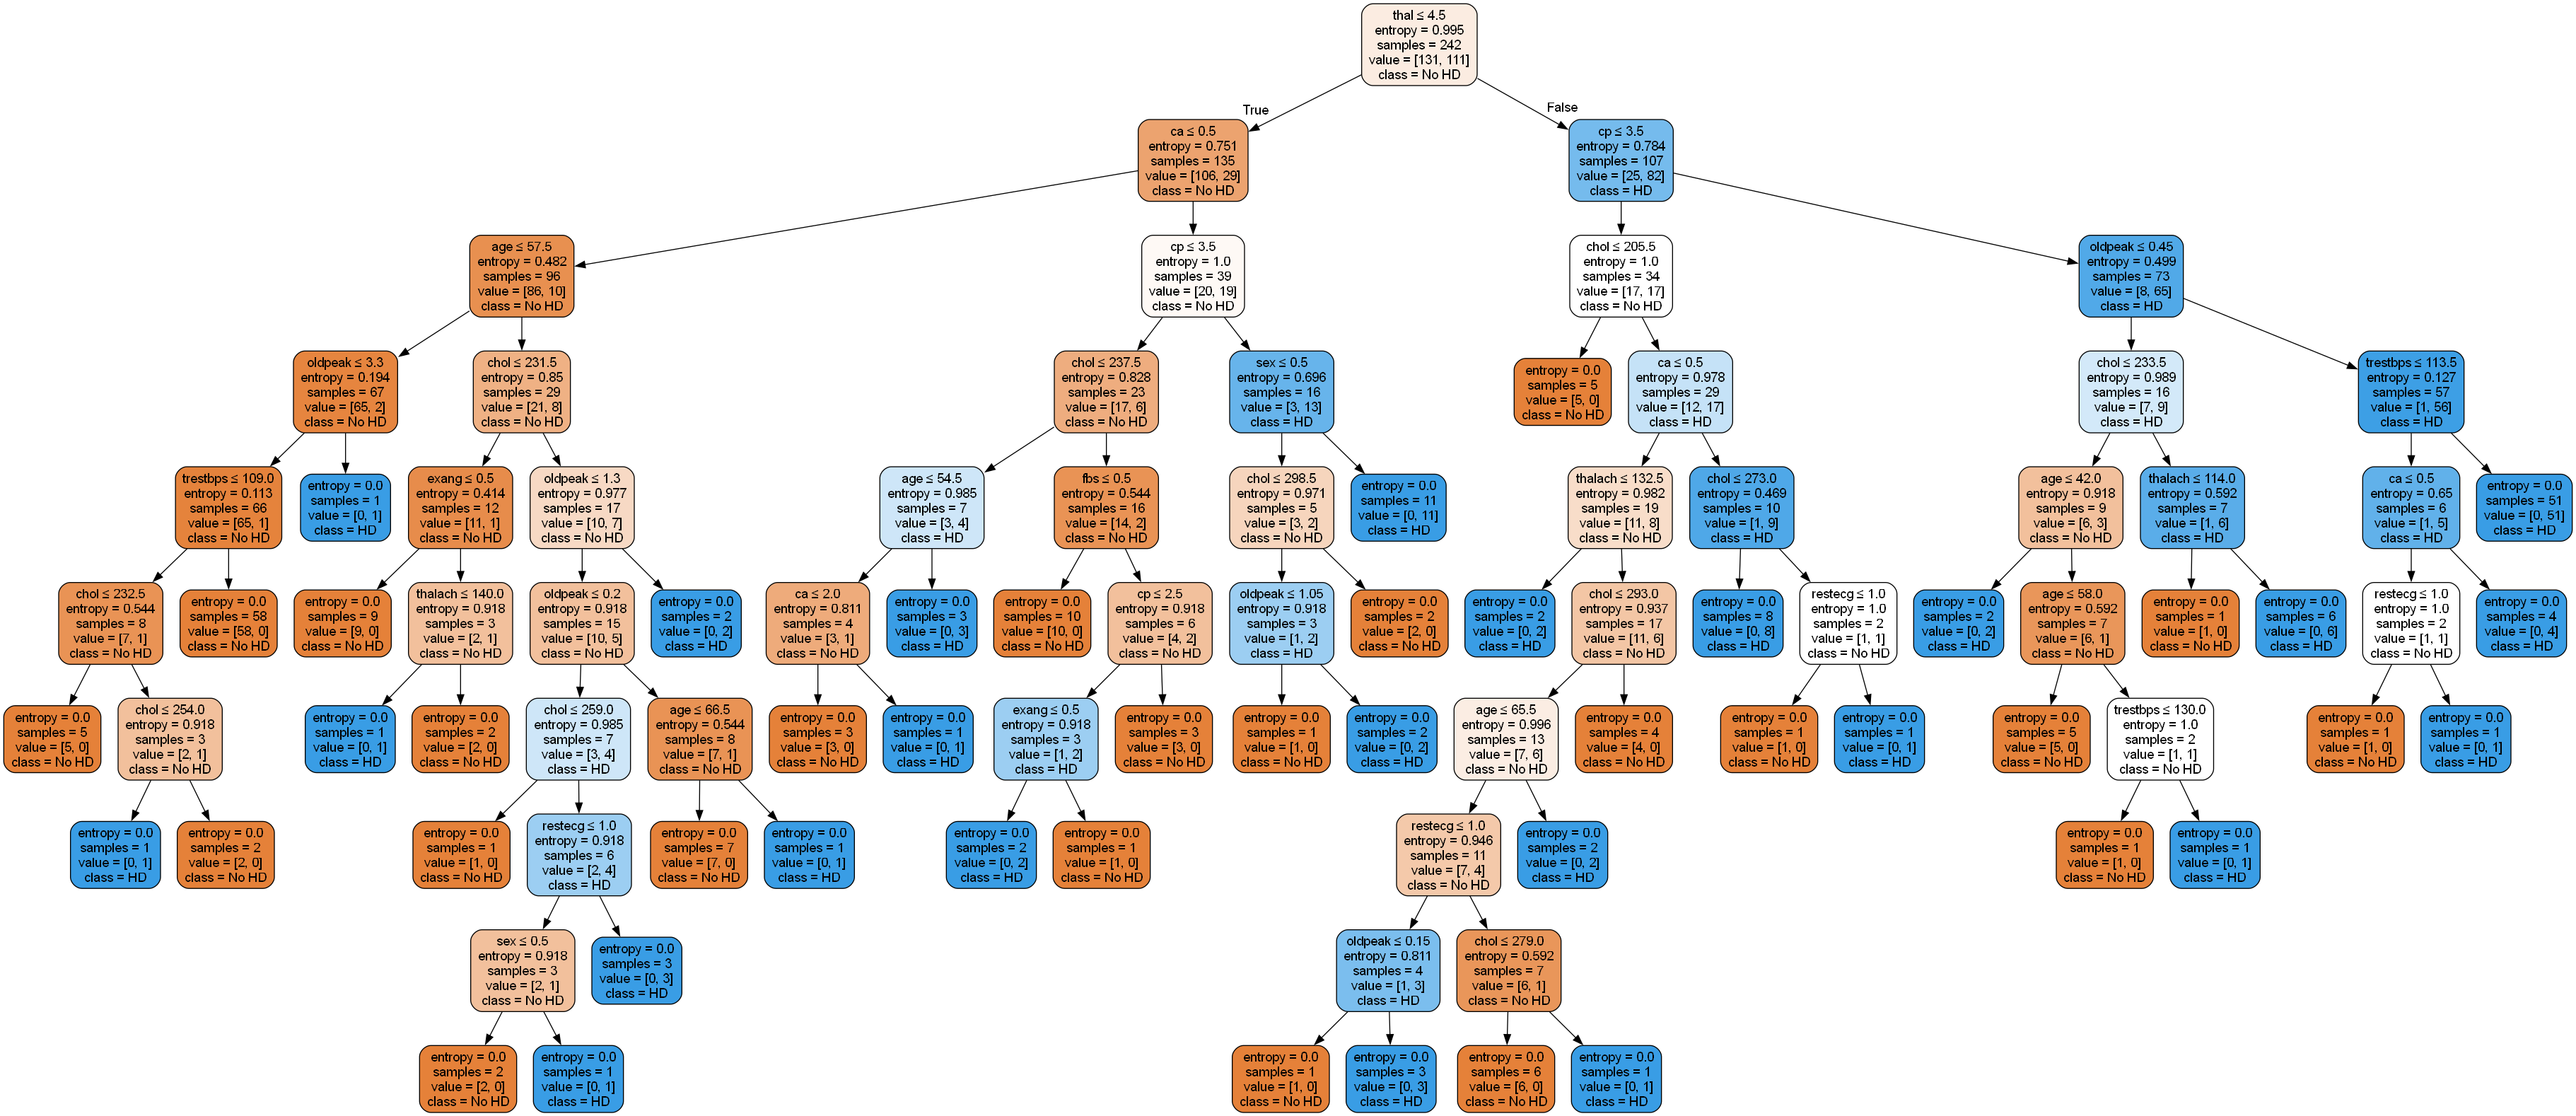


(process:10516): Pango-CRITICAL **: 07:07:21.751: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10516): Pango-CRITICAL **: 07:07:21.751: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10516): Pango-CRITICAL **: 07:07:21.751: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:10516): Pango-CRITICAL **: 07:07:21.751: pango_font_description_get_family: assertion 'desc != NULL' failed


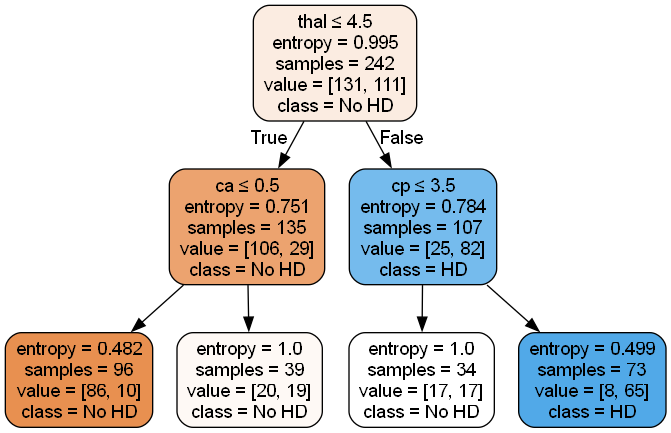


(process:4996): Pango-CRITICAL **: 07:07:22.387: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4996): Pango-CRITICAL **: 07:07:22.387: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4996): Pango-CRITICAL **: 07:07:22.387: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:4996): Pango-CRITICAL **: 07:07:22.387: pango_font_description_get_family: assertion 'desc != NULL' failed


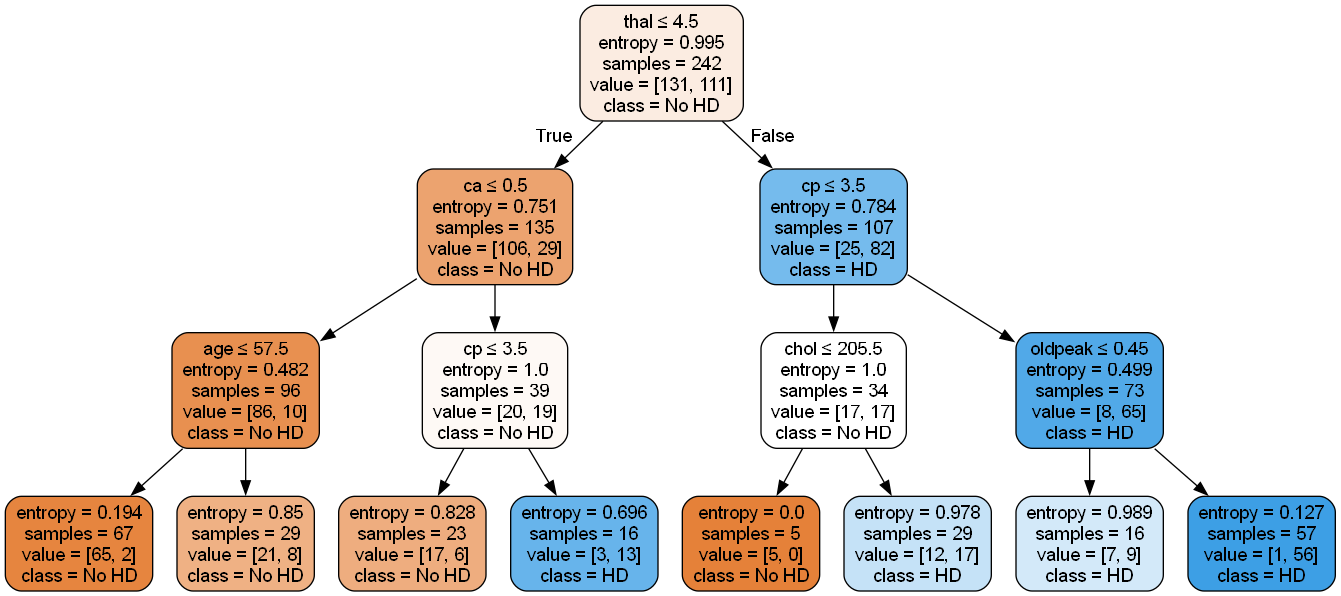


(process:15112): Pango-CRITICAL **: 07:07:23.065: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15112): Pango-CRITICAL **: 07:07:23.065: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15112): Pango-CRITICAL **: 07:07:23.065: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:15112): Pango-CRITICAL **: 07:07:23.065: pango_font_description_get_family: assertion 'desc != NULL' failed


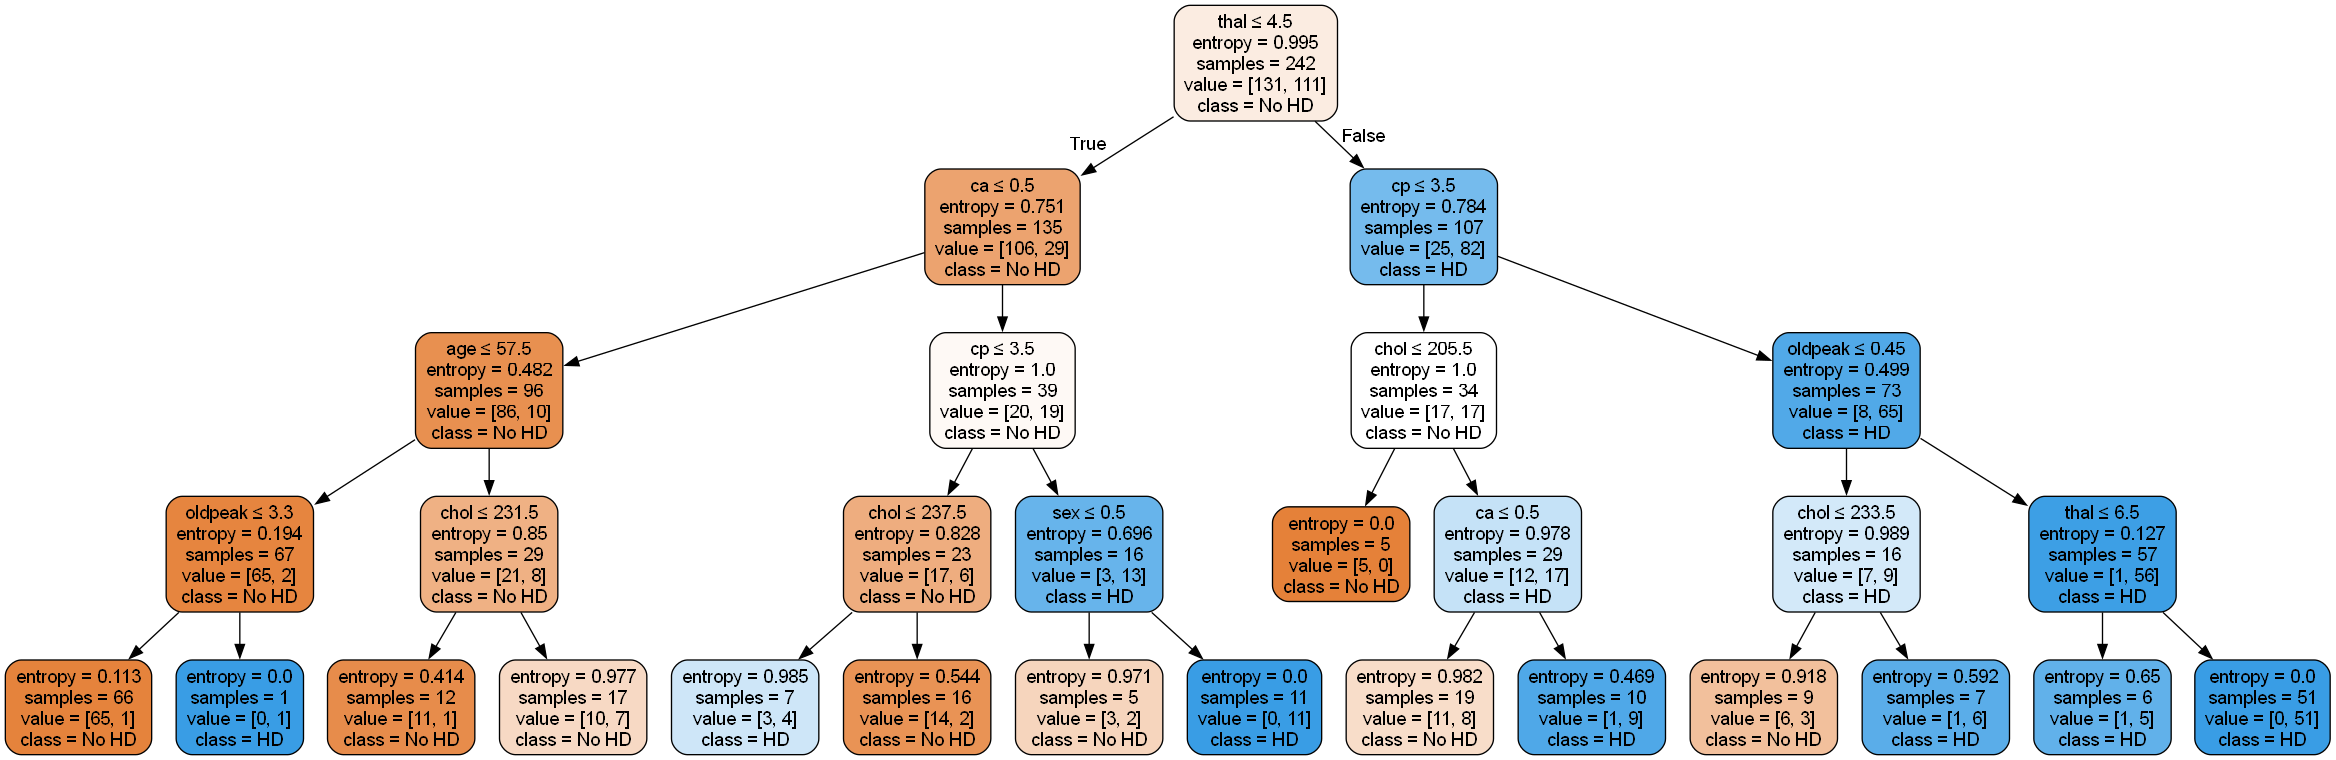


(process:6384): Pango-CRITICAL **: 07:07:23.822: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6384): Pango-CRITICAL **: 07:07:23.822: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6384): Pango-CRITICAL **: 07:07:23.822: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:6384): Pango-CRITICAL **: 07:07:23.822: pango_font_description_get_family: assertion 'desc != NULL' failed


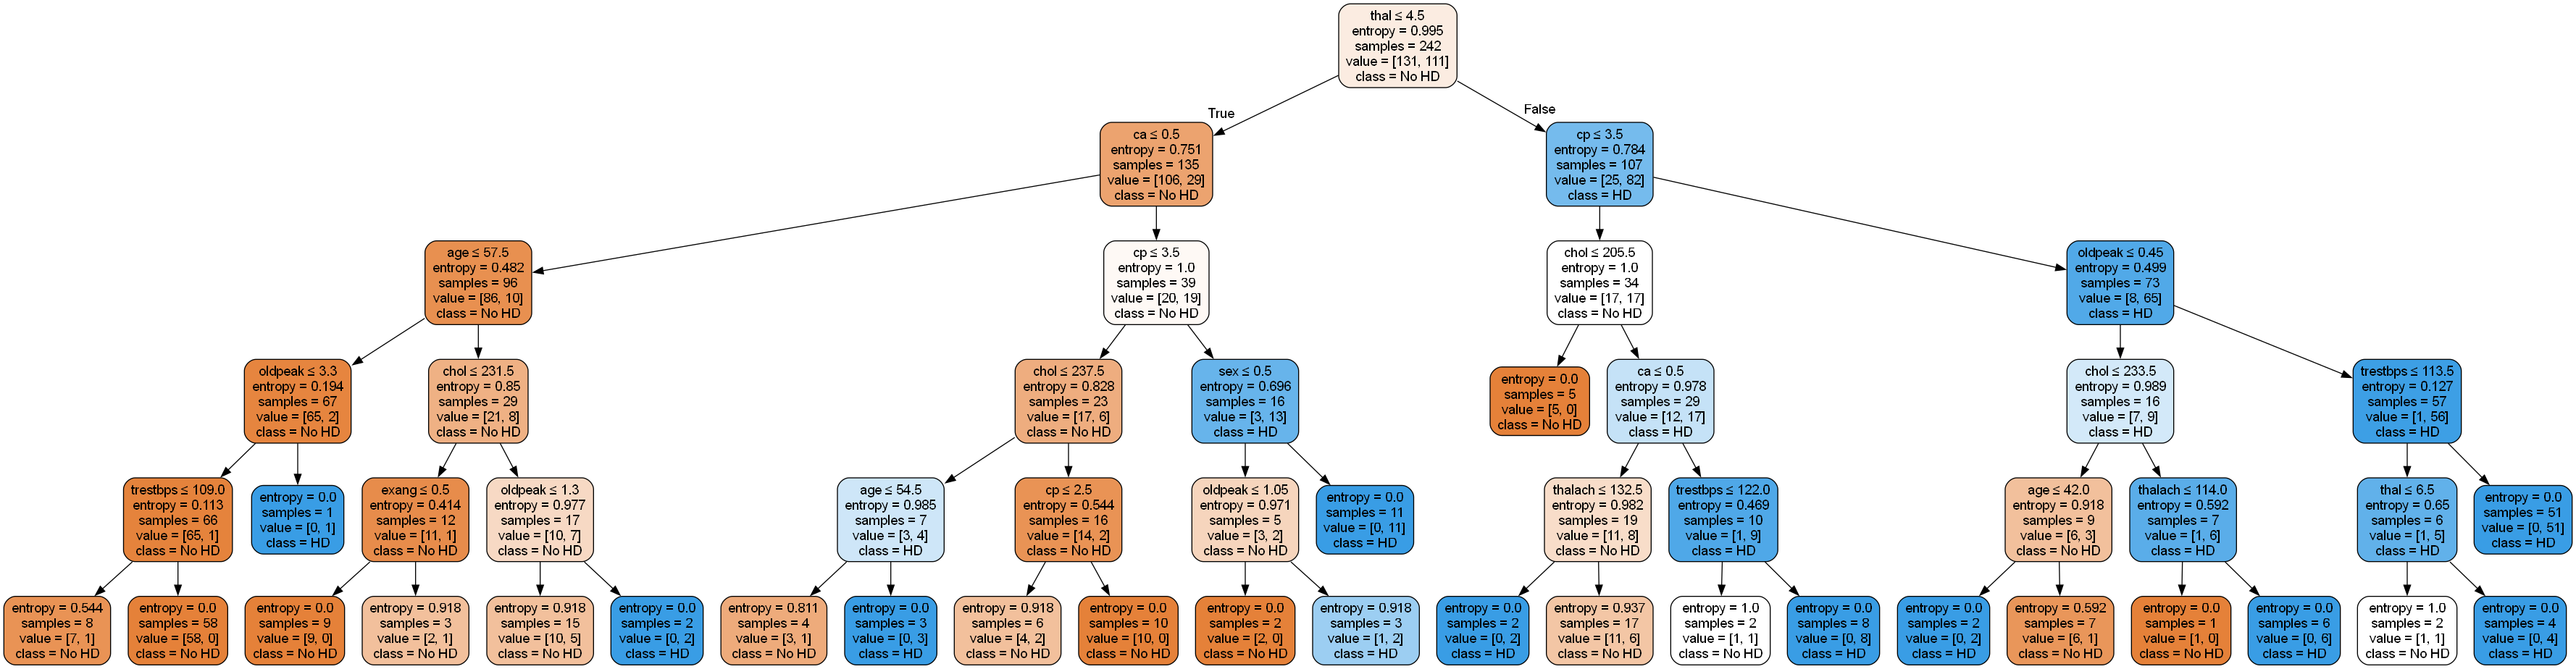


(process:2236): Pango-CRITICAL **: 07:07:24.639: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2236): Pango-CRITICAL **: 07:07:24.639: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2236): Pango-CRITICAL **: 07:07:24.639: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:2236): Pango-CRITICAL **: 07:07:24.639: pango_font_description_get_family: assertion 'desc != NULL' failed


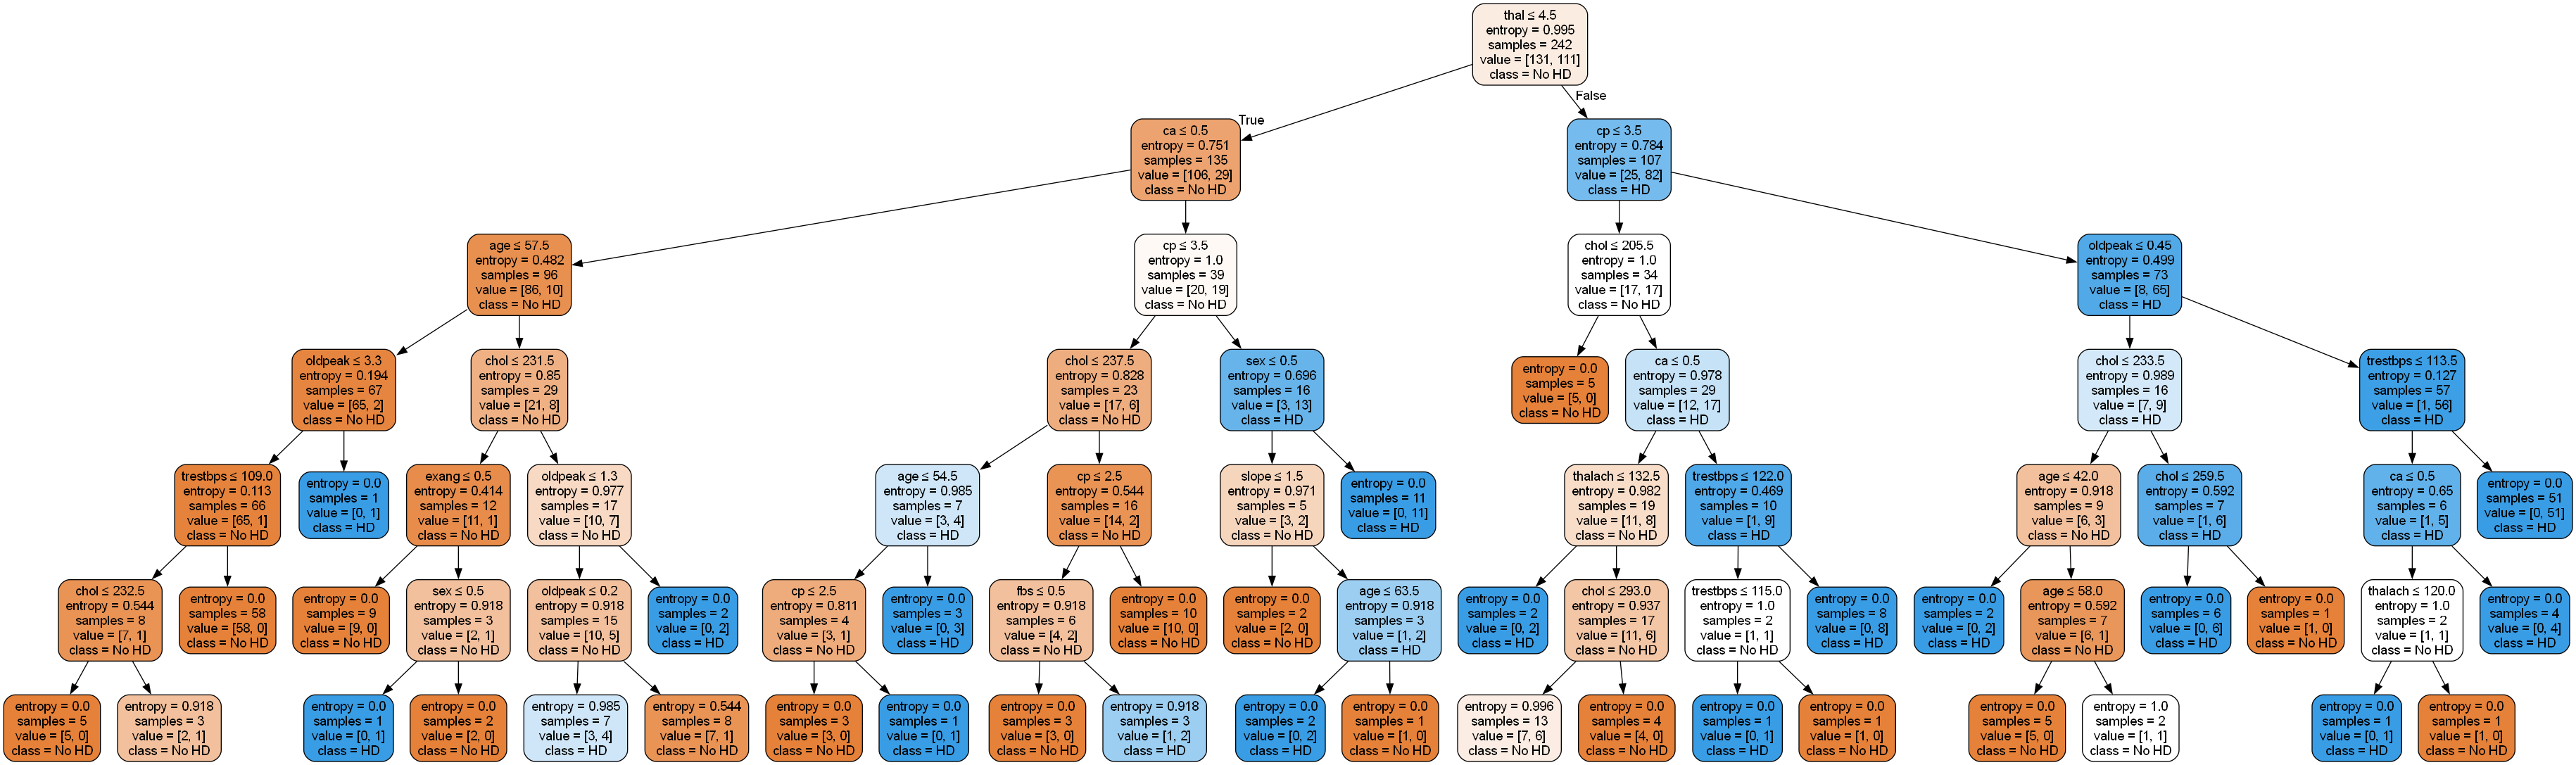


(process:13588): Pango-CRITICAL **: 07:07:25.435: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13588): Pango-CRITICAL **: 07:07:25.435: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13588): Pango-CRITICAL **: 07:07:25.435: pango_font_description_get_family: assertion 'desc != NULL' failed

(process:13588): Pango-CRITICAL **: 07:07:25.435: pango_font_description_get_family: assertion 'desc != NULL' failed


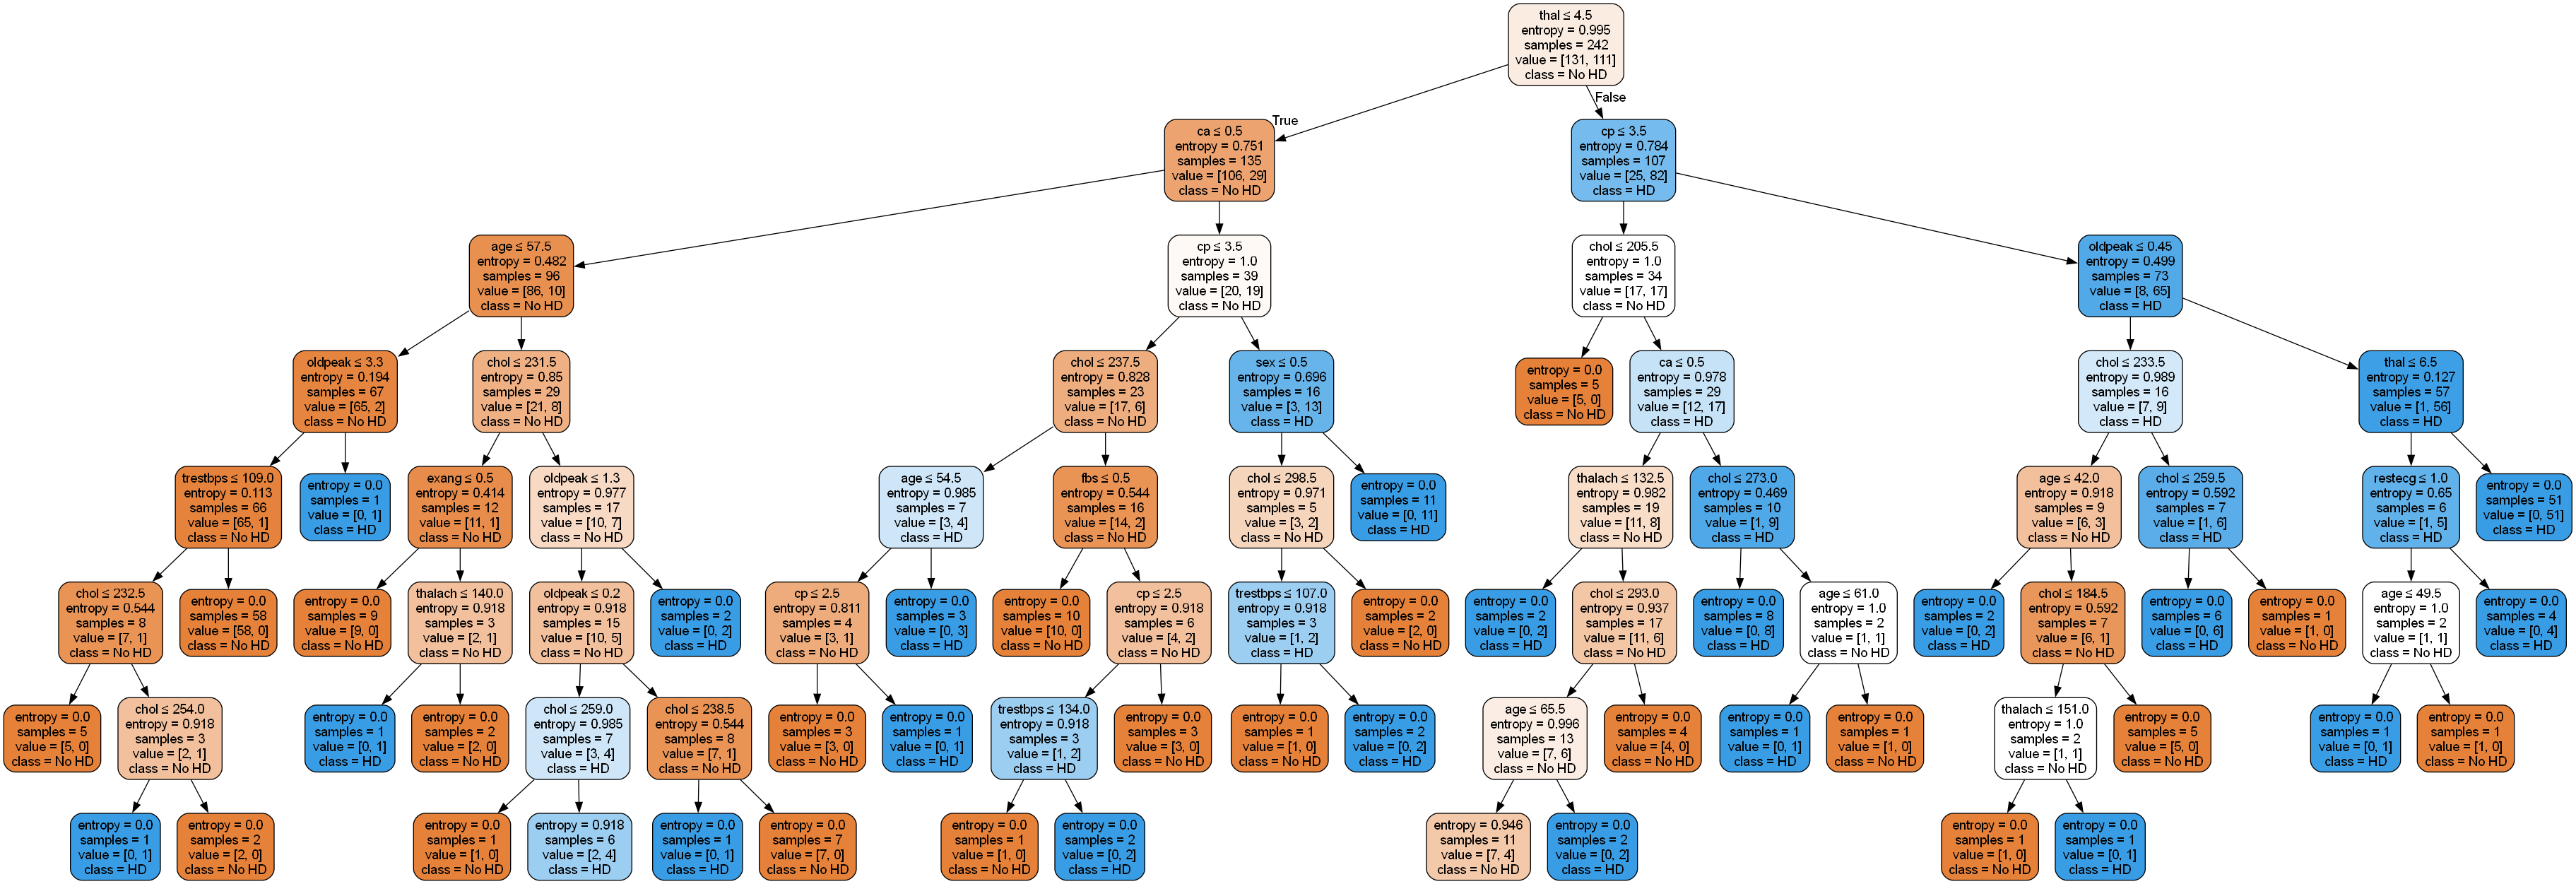

In [8]:
# Chia dữ liệu 80/20 với y_binary
base_depth_path = './output/depth_accuracy'
os.makedirs(base_depth_path, exist_ok=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, train_size=0.8, stratify=y_binary, shuffle=True, random_state=42)

max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracies = []

for depth in max_depth_values:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

    # Trực quan hóa cây
    dot_data = export_graphviz(clf, out_file=None,
                               feature_names=X.columns,
                               class_names=['No HD', 'HD'],
                               filled=True, rounded=True,
                               special_characters=True)
    graph = graphviz.Source(dot_data)
    depth_label = "full" if depth is None else str(depth)
    graph.render(f"{base_depth_path}/decision_tree_maxdepth_{depth_label}", format='png', cleanup=True)
    display(Image(f"{base_depth_path}/decision_tree_maxdepth_{depth_label}.png"))


#### Bảng đánh giá và biểu đồ


Accuracy scores for different max_depth values:
Max Depth	Accuracy
Full Tree 	77.05%
2         	77.05%
3         	78.69%
4         	78.69%
5         	80.33%
6         	70.49%
7         	68.85%


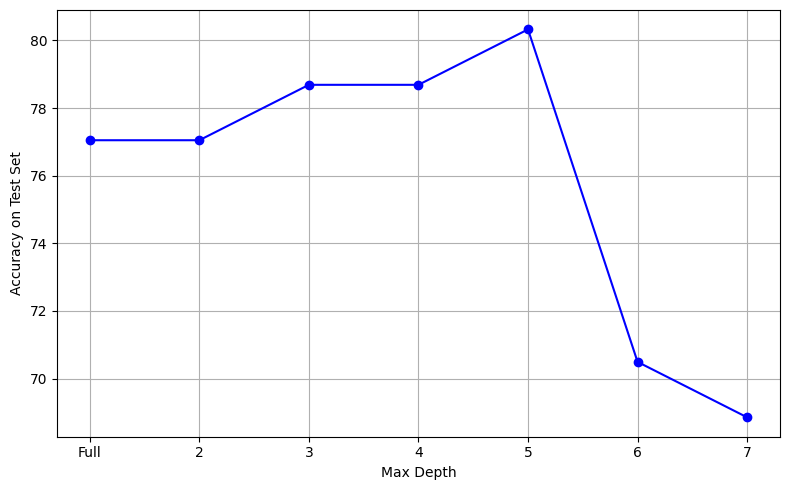

In [9]:
# In bảng accuracy
print("\nAccuracy scores for different max_depth values:")
print("Max Depth\tAccuracy")
for depth, acc in zip(max_depth_values, accuracies):
    label = "Full Tree" if depth is None else str(depth)
    print(f"{label:<10}\t{acc * 100:.2f}%") 

# Vẽ biểu đồ
labels = ['Full' if d is None else str(d) for d in max_depth_values]

plt.figure(figsize=(8, 5))
# Chuyển accuracies sang phần trăm
accuracies_percent = [acc * 100 for acc in accuracies]
plt.plot(labels, accuracies_percent, marker='o', linestyle='-', color='blue')
plt.ylabel("Accuracy on Test Set (%)")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy on Test Set")
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{base_depth_path}/accuracy_chart.png', format='png', bbox_inches='tight')
plt.show()